In [1]:
import sys
sys.path.insert(0, '../src')

/mnt/c/Users/Jacob/Desktop/prosjektoppgave/tcav_atari/src


In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import scipy
import torch
from matplotlib.colors import CenteredNorm
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

from concepts import concept_instances
from sk_probing import train_probe
from utils import load_game_data, load_q_network_device

In [3]:
game_data = load_game_data()

max_data_size = 1000
max_iter = 200
k_fold = 5
num_reg = 5
layer = '5'

actions = ['Noop', 'Fire', 'Right', 'Left']
q_network, device = load_q_network_device(model_path="../runs/20231107-224748/models/model_1668100.pt")
q_network.to('cpu')

QNetwork(
  (network): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [4]:
#test_concepts = ['random (b)', 'ball left for paddle (b)', 'ball right for paddle (b)', 'paddle x', 'ball x', 'ball y', 'ball low (b)', 'ball going down (b)']
#concept_instances = {concept: concept_instances[concept] for concept in test_concepts}

In [5]:
probes = {}
concept_names = []
for concept in concept_instances.values():
    concept_names.append(concept.name)
    concept.prepare_data(game_data)
    probe, score = train_probe(q_network, concept, layer, max_iter, k_fold, num_reg)
    probes[concept.name] = probe
    print(f'{concept.name}: {score}')

ball y: 0.6941257576249689
ball x: 0.8795601603088373
ball low (b): 0.9926650366748166
ball collision (b): 0.8063583815028901
ball going right (b): 0.668235294117647
ball going left (b): 0.6658823529411764
ball going up (b): 0.9246231155778895
ball going down (b): 0.9045226130653266
ball speed: 0.15675708284372236
paddle x: 0.9709461795343317
ball left for paddle (b): 0.6994535519125684
ball right for paddle (b): 0.6744186046511629
ball above paddle (b): 0.46445497630331745
ball paddle distance: 0.8485007020708503
lives: 0.5921346133163317
last life (b): 0.9920634920634921
losing life (b): 0.9780219780219781
random (b): -0.04044943820224722
brick hit (b): 0.8823529411764706
bricks hit: 0.9858903053066839


In [6]:
np.random.shuffle(game_data)

In [7]:
train_x = []
train_y_q = []
train_y_action = []
for game_step in game_data[:int(len(game_data)*0.8)]:
    # were just using normal concept functions here, but would it be beneficial to use the probe values instead?
    # i guess normally you would not have these functions, so then we would have to use the probes
    concept_vector = []
    for concept in concept_instances.values():
        concept_vector.append(concept.value_function(game_step.state_variables))
    train_x.append(concept_vector)
    q_values = q_network(torch.tensor(game_step.observation, dtype=torch.float32).unsqueeze(0)).detach().numpy()[0]
    train_y_q.append(np.max(q_values))
    train_y_action.append(np.argmax(q_values))
train_x = np.array(train_x)
train_y_q = np.array(train_y_q)
train_y_action = np.array(train_y_action)

In [8]:
test_x = []
test_y_q = []
test_y_action = []
for game_step in game_data[int(len(game_data)*0.8):]:
    concept_vector = []
    for concept in concept_instances.values():
        concept_vector.append(concept.value_function(game_step.state_variables))
    test_x.append(concept_vector)
    q_values = q_network(torch.tensor(game_step.observation, dtype=torch.float32).unsqueeze(0)).detach().numpy()[0]
    test_y_q.append(np.max(q_values))
    test_y_action.append(np.argmax(q_values))
test_x = np.array(test_x)
test_y_q = np.array(test_y_q)
test_y_action = np.array(test_y_action)

In [9]:
print('train_x shape:', train_x.shape)
print('train_y_q shape:', train_y_q.shape)
print('train_y_action shape:', train_y_action.shape)
print('test_x shape:', test_x.shape)
print('test_y_q shape:', test_y_q.shape)
print('test_y_action shape:', test_y_action.shape)

train_x shape: (3616, 20)
train_y_q shape: (3616,)
train_y_action shape: (3616,)
test_x shape: (904, 20)
test_y_q shape: (904,)
test_y_action shape: (904,)


In [10]:
# divide x by std
#train_std = np.std(train_x, axis=0)
#train_x = train_x / train_std
#test_x = test_x / train_std

# divide x by max
train_max = np.max(train_x, axis=0)
train_x = train_x / train_max
test_x = test_x / train_max

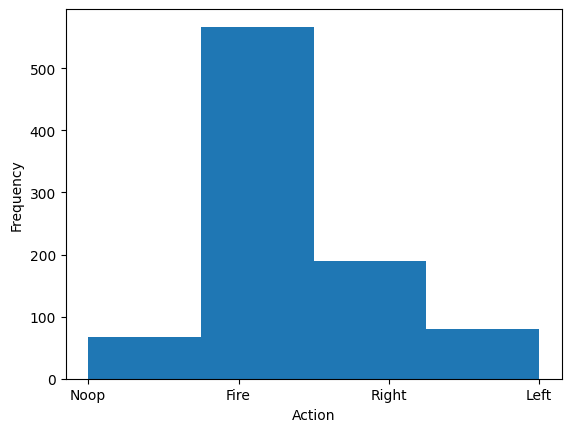

Noop: 0.07411504424778761
Fire: 0.6272123893805309
Right: 0.21017699115044247
Left: 0.08849557522123894


In [11]:
plt.hist(test_y_action, bins=4)
plt.xticks(np.arange(4), actions)
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.show()

# what is the ratio of each action?
for action in actions:
    print(f'{action}: {np.sum(test_y_action == actions.index(action)) / len(test_y_action)}')

train accuracy: 0.6280420353982301
test accuracy: 0.6559734513274337


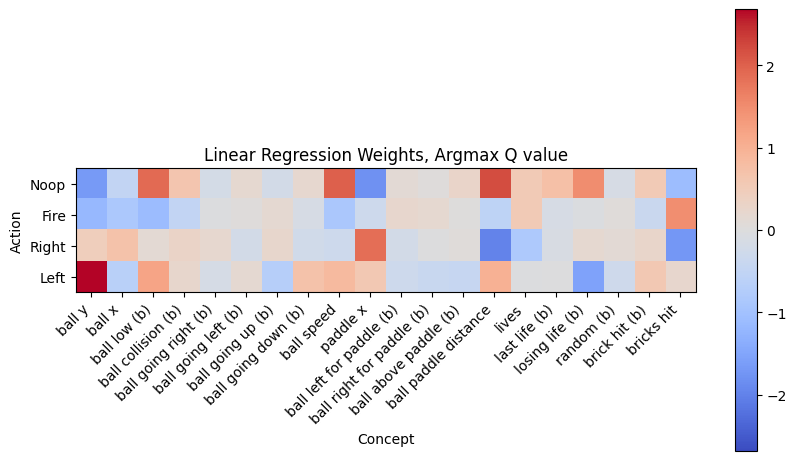

In [12]:
reg = linear_model.LogisticRegression(multi_class='ovr')
reg.fit(train_x, train_y_action)
print('train accuracy:', accuracy_score(train_y_action, reg.predict(train_x)))
print('test accuracy:', accuracy_score(test_y_action, reg.predict(test_x)))

fig, ax = plt.subplots(figsize=(10, 7))
norm = CenteredNorm()
im = ax.imshow(reg.coef_, cmap='coolwarm', norm=norm)

ax.set_xticks(np.arange(len(concept_instances)))
ax.set_yticks(np.arange(len(actions))) 
ax.set_xticklabels([concept.name for concept in concept_instances.values()], rotation=45, ha='right')
ax.set_yticklabels(actions)

ax.set_xlabel('Concept')
ax.set_ylabel('Action')
ax.set_title('Linear Regression Weights, Argmax Q value')

cbar = plt.colorbar(im, ax=ax, shrink=0.82, aspect=20)
plt.show()

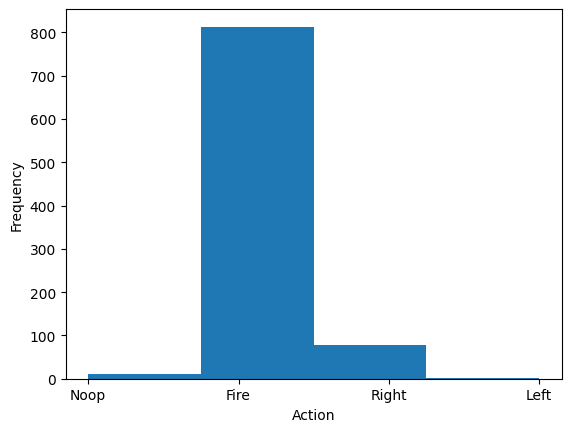

In [13]:
yhat = reg.predict(test_x)
# plot histogram
plt.hist(yhat, bins=4)
plt.xticks(np.arange(4), actions)
plt.xlabel('Action')
plt.ylabel('Frequency')
plt.show()

In [18]:
# Create a Decision Tree Classifier
dtree = DecisionTreeClassifier(max_depth=2)

# Fit the model with your training data
dtree.fit(train_x, train_y_action)

print('train accuracy:', accuracy_score(train_y_action, dtree.predict(train_x)))
print('test accuracy:', accuracy_score(test_y_action, dtree.predict(test_x)))

train accuracy: 0.6274889380530974
test accuracy: 0.6238938053097345


In [19]:
from sklearn.ensemble import RandomForestClassifier

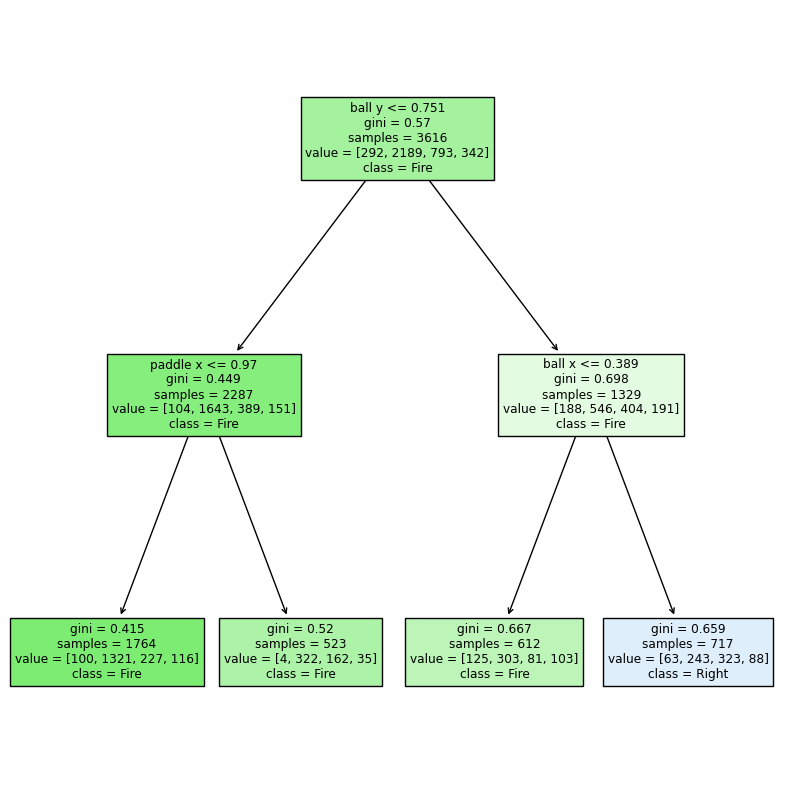

In [21]:
plt.figure(figsize=(10, 10))  # Adjust the size to your preference
plot_tree(dtree, filled=True, feature_names=concept_names, class_names=actions)
plt.show()

In [20]:
rf = RandomForestClassifier(n_estimators=1000)

# Fit the model with your training data
rf.fit(train_x, train_y_action)

print('train accuracy:', accuracy_score(train_y_action, rf.predict(train_x)))
print('test accuracy:', accuracy_score(test_y_action, rf.predict(test_x)))

train accuracy: 1.0
test accuracy: 0.7212389380530974
